正如我们在 9.5节中看到的，机器翻译中的输入序列和输出序列都是长度可变的。为了解决这类问题，我们在 9.6节中设计了一个通用的”编码器－解码器“架构。本节，我们将使用两个循环神经网络的编码器和解码器，并将其应用于序列到序列（sequence to sequence，seq2seq）类的学习任务 (Cho et al., 2014, Sutskeveret al., 2014)。

遵循编码器－解码器架构的设计原则，循环神经网络编码器使用长度可变的序列作为输入，将转换为固定形状的隐状态。换言之，输入序列的信息被编码到循环神经网络编码器的隐状态中。为了连续生成输出序列的词元，独立的循环神经网络解码器是基于输入序列的编码信息和输出序列已经看见的或者生成的词元来预测下一个词元。图9.7.1演示了如何在机器翻译中使用两个循环神经网络进行序列到序列学习。
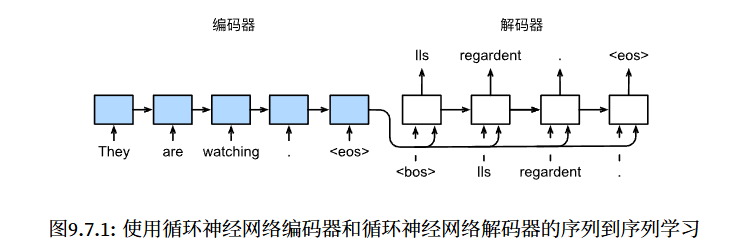

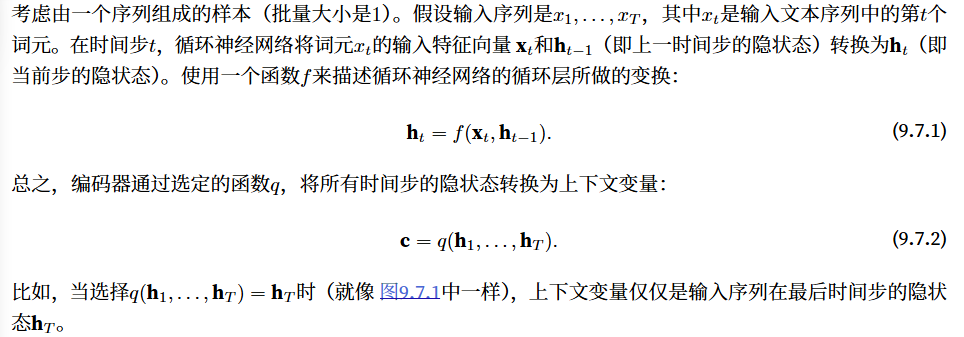
到目前为止，我们使用的是一个单向循环神经网络来设计编码器，其中隐状态只依赖于输入子序列，这个子序列是由输入序列的开始位置到隐状态所在的时间步的位置（包括隐状态所在的时间步）组成。我们也可以使用双向循环神经网络构造编码器，其中隐状态依赖于两个输入子序列，两个子序列是由隐状态所在的时间步的位置之前的序列和之后的序列（包括隐状态所在的时间步），因此隐状态对整个序列的信息都进行了编码。

现在，让我们实现循环神经网络编码器。注意，我们使用了嵌入层（embedding layer）来获输入序列中每个词元的特征向量。嵌入层的权重是一个矩阵，其行数等于输入词表的大小（vocab_size），其列数等于特征向量的维度（embed_size）。对于任意输入词元的索引i，嵌入层获取权重矩阵的第i行（从0开始）以返回其特征向量。另外，本文选择了一个多层门控循环单元来实现编码器。

In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def  __init__(self,vocab_size,embed_size,num_hiddens,num_layers,dropout=0,**kwargs):
        super(Seq2SeqEncoder,self).__init__(**kwargs)
        #嵌入层
        self.embedding=nn.Embedding(vocab_size,embed_size)
        self.rnn=nn.GRU(embed_size,num_hiddens,num_layers,dropout=dropout)

    def forward(self,X,*args):
        #输出'X'的形状：(batch_size,num_steps,embed_size)
        X=self.embedding(X)
        #在循环神经网络模型中，第一个轴对应时间步
        X=X.permute(1,0,2)
        #如果未提及状态则默认为0
        output,state=self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

下面，我们实例化上述编码器的实现：我们使用一个两层门控循环单元编码器，其隐藏单元数为16。给定一
小批量的输入序列X（批量大小为4，时间步为7）。在完成所有时间步后，最后一层的隐状态的输出是一个张
量（output由编码器的循环层返回），其形状为（时间步数，批量大小，隐藏单元数）。

In [3]:
encoder=Seq2SeqEncoder(vocab_size=10,embed_size=8,num_hiddens=16,num_layers=2)
encoder.eval()
X=torch.zeros((4,7),dtype=torch.long)
output,state=encoder(X)
output.shape

torch.Size([7, 4, 16])

#### 解码器
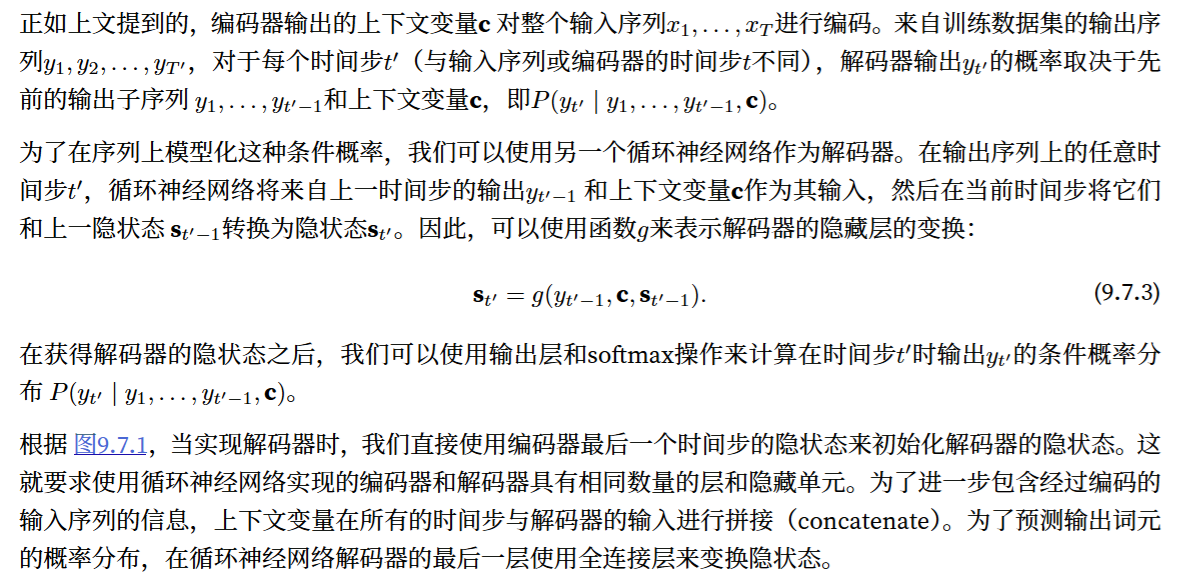

In [4]:
#解码器
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,dropout=0,**kwargs):
        super(Seq2SeqDecoder,self).__init__(**kwargs)
        self.embedding=nn.Embedding(vocab_size,embed_size)
        self.rnn=nn.GRU(embed_size+num_hiddens,num_hiddens,num_layers,dropout=dropout)
        self.dense=nn.Linear(num_hiddens,vocab_size)
    def init_state(self,enc_outputs,*args):
        return enc_outputs[1]
    
    def forward(self,X,state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context上下文变量，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)#拼接
        output,state=self.rnn(X_and_context,state)
        output=self.dense(output).permute(1,0,2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [5]:
decoder=Seq2SeqDecoder(vocab_size=10,embed_size=8,num_hiddens=16,num_layers=2)
decoder.eval()
state=decoder.init_state(encoder(X))
output,state=decoder(X,state)
output.shape,state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

上述RNN“编码器-解码器”模型中各层如图所示：
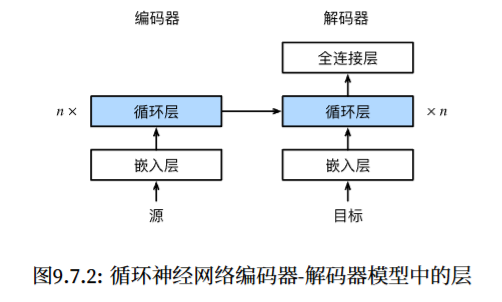

在每个时间步，解码器预测了输出词元的概率分布。类似于语言模型，可以使用softmax来获得分布，并通过计算交叉熵损失函数来进行优化。回想一下 9.5节中，特定的填充词元被添加到序列的末尾，因此不同长度的序列可以以相同形状的小批量加载。但是，我们应该将填充词元的预测排除在损失函数的计算之外。

为此，我们可以使用下面的sequence_mask函数通过零值化屏蔽不相关的项，以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。例如，如果两个序列的有效长度（不包括填充词元）分别为1和2，则第一个序列的第一项和第二个序列的前两项之后的剩余项将被清除为零。

In [ ]:
#@save
#序列掩码操作
def sequence_mask(X,valid_len,value=0):#value控制指定的掩码替换值
    """在序列中屏蔽不相关的项"""
    maxlen=X.size(1)
    mask=torch.arange((maxlen),dtype=torch.float32,
                      device=X.device)[None,:]<valid_len[:,None]
                    #作用是生成一个布尔型掩码矩阵，标出哪些位置是“有效的”
    X[~mask]=value
    return X
#torch.arange(n)生成一个从 0 到 n-1 的等差整数序列. 它和Python原生的range(n)类似,只不过生成的是张量（tensor）而不是列表（list）

现在，我们可以通过扩展softmax交叉熵损失函数来遮蔽不相关的预测。最初，所有预测词元的掩码都设置为1。一旦给定了有效长度，与填充词元对应的掩码将被设置为0。最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。

In [7]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带掩码的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self,pred,label,valid_len):
        weights=torch.ones_like(label)
        weights=sequence_mask(weights,valid_len)
        self.reduction='none'
        unweighted_loss=super(MaskedSoftmaxCELoss,self).forward(
            pred.permute(0,2,1),label)
        weighted_loss=(unweighted_loss*weights).mean(dim=1)
        return weighted_loss

在下面的循环训练过程中，如 图9.7.1所示，特定的序列开始词元（“bos”）和原始的输出序列（不包括序列结束词元“eos”）拼接在一起作为解码器的输入。这被称为强制教学（teacher forcing），因为原始的输出序列（词元的标签）被送入解码器。或者，将来自上一个时间步的预测得到的词元作为解码器的当前输入。

In [16]:
#@save
def train_seq2seq(net, data_iter,lr,num_epochs,tgt_vocab,device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.GRU):
            for name, param in m.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer=torch.optim.Adam(net.parameters(),lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                    xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer=d2l.Timer()
        metric=d2l.Accumulator(2)#训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X,X_valid_len,Y,Y_valid_len=[x.to(device) for x in batch]
            bos=torch.tensor([tgt_vocab['<bos>']]*Y.shape[0],device=device).reshape(-1,1)
            dec_input=torch.cat([bos,Y[:,:-1]],1)   #强制教学
            Y_hat=net(X,dec_input,X_valid_len)
            l=loss(Y_hat,Y,Y_valid_len)
            l.sum().backward()  #损失函数的标量和进行反向传播
            d2l.grad_clipping(net,1)
            num_tokens=Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(),num_tokens)
        if(epoch+1)%10==0:
            animator.add(epoch+1,(metric[0]/metric[1],))
    print(f'loss {metric[0]/metric[1]:.3f},{metric[1]/timer.stop():.1f}'
          f'tokens/sec on {str(device)}')

loss 0.019,19430.7tokens/sec on cuda:0


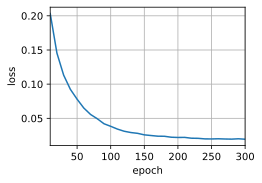

In [17]:
#创建和训练一个循环神经网络“编码器－解码器”模型
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

为了采用一个接着一个词元的方式预测输出序列，每个解码器当前时间步的输入都将来自于前一时间步的预测词元。与训练类似，序列开始词元（“bos”）在初始时间步被输入到解码器中。该预测过程如 图9.7.3所示，当输出序列的预测遇到序列结束词元（“eos”）时，预测就结束了。
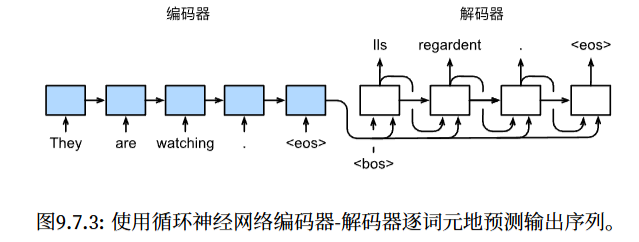

In [18]:
#预测
def predict_seq2seq(net,src_sentence,src_vocab,tgt_vocab,num_steps,device,    save_attention_weights=False):
    """序列到序列模型的预测"""
    #设置为评估模式
    net.eval()
    src_tokens=src_vocab[src_sentence.lower().split(' ')]+[
        src_vocab['<eos>']]
    enc_valid_len=torch.tensor([len(src_tokens)],device=device)
    src_tokens=d2l.truncate_pad(src_tokens,num_steps,src_vocab['<pad>'])
    #添加批量轴
    enc_X=torch.unsqueeze(
        torch.tensor(src_tokens,dtype=torch.long,device=device),dim=0)
    enc_outputs=net.encoder(enc_X,enc_valid_len)
    dec_state=net.decoder.init_state(enc_outputs,enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y,dec_state=net.decoder(dec_X,dec_state)
        #我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X=Y.argmax(dim=2)
        pred=dec_X.squeeze(dim=0).type(torch.int32).item()
        #保存注意力权重(稍后讨论)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

#### 预测序列的评估
我们可以通过与真实的标签序列进行比较来评估预测序列。虽然 (Papineni et al., 2002) 提出的BLEU（bilingualevaluation understudy）最先是用于评估机器翻译的结果，但现在它已经被广泛用于测量许多应用的输出序列的质量。原则上说，对于预测序列中的任意n元语法（n‐grams），BLEU的评估都是这个n元语法是否出现在标签序列中。
我们将BLEU定义为：
$$exp(min(0,1-\frac{len_{label}}{len_{pred}}))\prod_{n=1}^{k}p_{n}^{1/2^{n}}$$

其中$len_{label}$表示标签序列中的词元数和$len_{pred}$表示预测序列中的词元数，k是用于匹配的最长的n元语法。另外，用pn表示n元语法的精确度，它是两个数量的比值：第一个是预测序列与标签序列中匹配的n元语法的数量，第二个是预测序列中n元语法的数量的比率。具体地说，给定标签序列A、B、C、D、E、F 和预测序列A、B、B、C、D，我们有p1 = 4/5、p2 = 3/4、p3 = 1/3和p4 = 0。

根据 (9.7.4)中BLEU的定义，当预测序列与标签序列完全相同时，BLEU为1。此外，由于n元语法越长则匹配难度越大，所以BLEU为更长的n元语法的精确度分配更大的权重。具体来说，当pn固定时，p1/2nn 会随着n的增长而增加（原始论文使用p1/nn ）。而且，由于预测的序列越短获得的pn值越高，所以 (9.7.4)中乘法项之前的系数用于惩罚较短的预测序列。例如，当k = 2时，给定标签序列A、B、C、D、E、F 和预测序列A、B，尽管p1 = p2 = 1，惩罚因子exp(1 − 6/2) ≈ 0.14会降低BLEU。

In [19]:
#BLEU的实现：
def bleu(pred_seq,label_seq,k):#@save
    """计算BLEU"""
    pred_tokens,label_tokens=pred_seq.split(' '),label_seq.split(' ')
    len_pred,len_label=len(pred_tokens),len(label_tokens)
    score=math.exp(min(0,1-len_label/len_pred))
    for n in range(1,k+1):
        num_matches,label_subs=0,collections.defaultdict(int)
        for i in range(len_label-n+1):
            label_subs[' '.join(label_tokens[i:i+n])]+=1
        for i in range(len_pred-n+1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score*=math.pow(num_matches/(len_pred-n+1),math.pow(0.5,n))
    return score    

In [20]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => courez bientôt !, bleu 0.000
i'm home . => je suis calme !, bleu 0.418


小结
- 根据“编码器‐解码器”架构的设计，我们可以使用两个循环神经网络来设计一个序列到序列学习的模型。
- 在实现编码器和解码器时，我们可以使用多层循环神经网络。
- 我们可以使用遮蔽来过滤不相关的计算，例如在计算损失时。
- 在“编码器－解码器”训练中，强制教学方法将原始输出序列（而非预测结果）输入解码器。
- BLEU是一种常用的评估方法，它通过测量预测序列和标签序列之间的n元语法的匹配度来评估预测。

#### 9.8穷举搜索
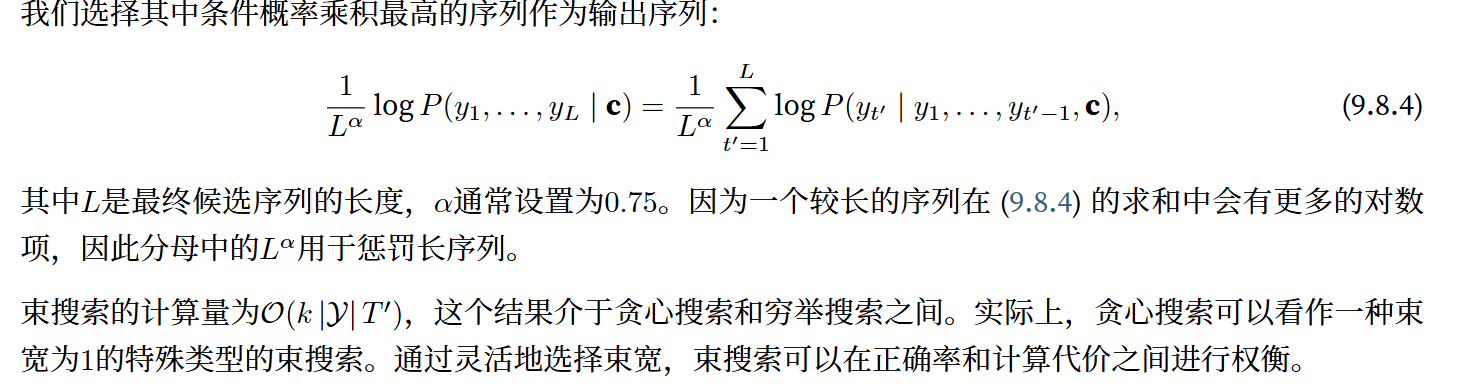
小结
- 序列搜索策略包括贪心搜索、穷举搜索和束搜索。
- 贪心搜索所选取序列的计算量最小，但精度相对较低。
- 穷举搜索所选取序列的精度最高，但计算量最大。
- 束搜索通过灵活选择束宽，在正确率和计算代价之间进行权衡。